# Motivation

It seems that none of the competitors was able to make a model that has a good performance. The first place achieved a score of 0.710, wich is only a little better than the sadbox submission 0.677. Almost every one pointed that applying feature engineering techniques didn't improve the model. So I decided to try to visualize the data and to have a hint about how it is useful for this classification test.

In [31]:
# data manipulation
import pandas as pd
import numpy as np

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import scale, normalize

# data visualization
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt

# dimensionality reduction
from sklearn.decomposition import PCA

**test 1 - Without feature engineering**

In [32]:
train = pd.read_csv('data/train.csv')
train = train.drop(['id_do_caso'], axis=1)
X_test = pd.read_csv('data/test.csv')

In [33]:
target_col = ['status_do_caso']

nominal_cols = ['continente', 'regiao_de_emprego']

ordinal_cols = [
    'tem_experiencia_de_trabalho', 
    'requer_treinamento_de_trabalho',
    'posicao_em_tempo_integral',
    'educacao_do_empregado',
    'unidade_de_salario',
]

In [34]:
train[target_col] = train[target_col].replace(['Negado', 'Aprovado'], [0, 1])

y_train = train[target_col].values.ravel()
train = train.drop(target_col, axis=1)

In [35]:
ordinal_encoder = OrdinalEncoder(categories=[
    ['N', 'S'], # tem_experiencia_de_trabalho
    ['N', 'S'], # requer_treinamento_de_trabalho
    ['N', 'S'], # posicao_em_tempo_integral
    ['Ensino Médio', 'Ensino Superior', 'Mestrado', 'Doutorado'], # educacao_do_empregado
    ['Hora', 'Semana', 'Mês', 'Ano'] # unidade_de_salario
])

train[ordinal_cols] = ordinal_encoder.fit_transform(train[ordinal_cols])
X_test[ordinal_cols] = ordinal_encoder.transform(X_test[ordinal_cols])

In [36]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[nominal_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[nominal_cols]))

OH_cols_train.index = train.index
OH_cols_test.index = X_test.index

X_train = train.drop(nominal_cols, axis=1)
X_test = X_test.drop(nominal_cols, axis=1)

OH_X_train = pd.concat([X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([X_test, OH_cols_test], axis=1)

OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

<Axes: xlabel='0', ylabel='1'>

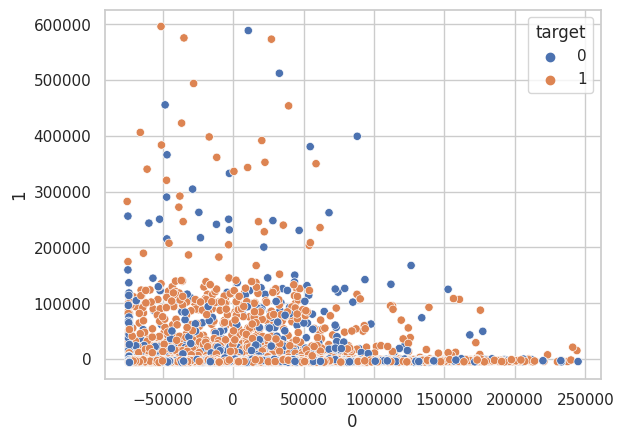

In [37]:
pca = PCA(2)
OH_X_train_2d = pca.fit_transform(OH_X_train)

OH_X_train_2d = pd.DataFrame(OH_X_train_2d)
OH_X_train_2d['target'] = y_train
sns.scatterplot(data=pd.DataFrame(OH_X_train_2d), x=0, y=1, hue="target")

In [38]:
print(f'Cumulative explained variation for 2 principal components: {np.sum(pca.explained_variance_ratio_)}')

Cumulative explained variation for 2 principal components: 0.9999994672738073


<Axes: xlabel='0', ylabel='1'>

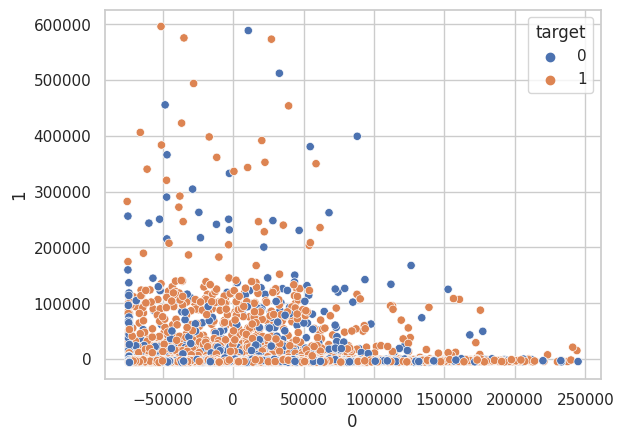

In [39]:
sns.scatterplot(data=pd.DataFrame(OH_X_train_2d), x=0, y=1, hue="target")

**test 2 - using feature engineering**

In [40]:
train = pd.read_csv('data/train.csv')
train = train.drop(['id_do_caso'], axis=1)
X_test = pd.read_csv('data/test.csv')

In [41]:
def padroniza_salario_por_hora(dataset_row):
    denominador_weight = 1
    
    if dataset_row['unidade_de_salario'] == 'Hora':
        return dataset_row['salario_prevalecente']

    # A variável denominador_weight irá dimunir o valor da variável denominador caso a posição de trabalho seja de meio período
    if dataset_row['posicao_em_tempo_integral'] == 'N':
        denominador_weight = 0.5

    # horas úteis de trabalho em cada unidade de tempo
    if dataset_row['unidade_de_salario'] == 'Semana':
        denominador = 40
    elif dataset_row['unidade_de_salario'] == 'Mês':
        denominador = 172
    elif dataset_row['unidade_de_salario'] == 'Ano':
        denominador = 2064
    
    return round(dataset_row['salario_prevalecente'] / (denominador * denominador_weight), 2)

In [42]:
train['salario_prevalecente_hora'] = train.apply(padroniza_salario_por_hora, axis=1)
train = train.drop(['salario_prevalecente', 'unidade_de_salario'], axis=1)

In [43]:
target_col = ['status_do_caso']

nominal_cols = ['continente', 'regiao_de_emprego']

ordinal_cols = [
    'tem_experiencia_de_trabalho', 
    'requer_treinamento_de_trabalho',
    'posicao_em_tempo_integral',
    'educacao_do_empregado'
]

In [44]:
train[target_col] = train[target_col].replace(['Negado', 'Aprovado'], [0, 1])
y_train = train[target_col].values.ravel()
train = train.drop(target_col, axis=1)

In [45]:
ordinal_encoder = OrdinalEncoder(categories=[
    ['N', 'S'], # tem_experiencia_de_trabalho
    ['N', 'S'], # requer_treinamento_de_trabalho
    ['N', 'S'], # posicao_em_tempo_integral
    ['Ensino Médio', 'Ensino Superior', 'Mestrado', 'Doutorado'], # educacao_do_empregado
])

train[ordinal_cols] = ordinal_encoder.fit_transform(train[ordinal_cols])

In [46]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[nominal_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[nominal_cols]))

OH_cols_train.index = train.index
OH_cols_test.index = X_test.index

X_train = train.drop(nominal_cols, axis=1)
X_test = X_test.drop(nominal_cols, axis=1)

OH_X_train = pd.concat([X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([X_test, OH_cols_test], axis=1)

OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

<Axes: xlabel='0', ylabel='1'>

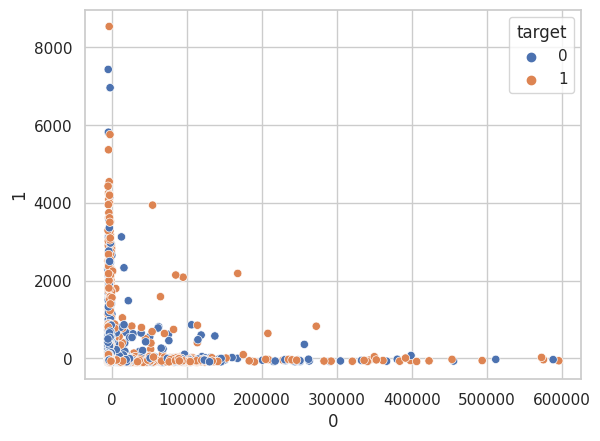

In [47]:
pca = PCA(2)
OH_X_train_2d = pca.fit_transform(OH_X_train)

OH_X_train_2d = pd.DataFrame(OH_X_train_2d)
OH_X_train_2d['target'] = y_train
sns.scatterplot(data=pd.DataFrame(OH_X_train_2d), x=0, y=1, hue="target")

In [48]:
print(f'Cumulative explained variation for 2 principal components: {np.sum(pca.explained_variance_ratio_)}')

Cumulative explained variation for 2 principal components: 0.9999967416161687


# Conclusion

It seems to me that this data is not good for the predictions we are trying to make, the data is not linearly separable and can not be separate using more complex equations. That's probably why the kaggle competitors complained that none of the feature engineering techniques worked.